First, import necessary tools for the analysis

In [1]:
import pandas as pd
import os              # To interact with finder
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Practical 5 Numeric data (Pandas)

## 1. Setting up data

### 1.1 Downloading and saving data

In [2]:
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        path = os.path.split(dest)
        
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

In [3]:
ddir  = os.path.join('data','raw') # destination directory
url = 'https://github.com/jreades/i2p/raw/master/data/src/2020-08-24-listings.csv.gz' # source path
fn  = os.path.split(url)[-1]

df_full = pd.read_csv(cache_data(url, ddir), compression = 'gzip', low_memory=False)

print('Done.')

Found data/raw/2020-08-24-listings.csv.gz locally!
Done.


### 1.2 Loading data

In [6]:
# Reset the working dataframe and load necessary columns for this analysis from the local file

cols = ['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id', 'host_name', 'host_since', 
        'host_location', 'host_about', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
        'host_listings_count', 'host_total_listings_count', 'host_verifications', 'latitude', 'longitude', 
        'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 
        'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 
        'first_review', 'last_review', 'review_scores_rating', 'review_scores_cleanliness', 
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'license', 
        'instant_bookable', 'calculated_host_listings_count', 'reviews_per_month']

df = pd.read_csv(cache_data(url, ddir), low_memory=False, usecols=cols)

Found data/raw/2020-08-24-listings.csv.gz locally!


### 1.3 Inspecting data

In [7]:
#Basic information about the dataframe
'''
print(df.shape[0], df.shape[1])      # Dimension
print(df.info())                     # Column, non-na count, data type
print(list(df.columns.values) )      # Column names
print(df.sample(6, random_state=42)) # Random sample entry
'''

# Random sample, necessary columns
df.sample(6, random_state=42)[['id', 'price', 'room_type', 'host_location', 'last_review', 'review_scores_rating']]

,id,price,room_type,host_location,last_review,review_scores_rating
36626,25337129.0,$170.00,Entire home/apt,GB,2018-06-21,100.0
54419,36333276.0,$75.00,Entire home/apt,"London, England, United Kingdom",2020-07-27,93.0
27090,20097189.0,$18.00,Private room,London,2017-10-28,100.0
71147,43862566.0,$410.00,Entire home/apt,"Fort Lauderdale, Florida, United States",NaN,NaN
43164,29649016.0,$250.00,Entire home/apt,"London, England, United Kingdom",NaN,NaN
7480,6650328.0,$200.00,Entire home/apt,"London, United Kingdom",2015-08-16,100.0


## 2. Cleaning data

### 2.1 Dealing with NaN

`[[<column names>]]`: selecting the columns to show
`df[<selection criteria>]`: selecting column entries fulfilling the selection criteria

In [8]:
# Find na entries for df.id and show important columns
df[df.id.isna()][['id','listing_url','name','description','host_id','host_name']]

,id,listing_url,name,description,host_id,host_name
3559,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/1c171...,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern..."
29990,NaN,within an hour,f,https://a0.muscache.com/im/pictures/user/19315...,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum..."


In [9]:
# Remove this entry
df.drop(index = df[df.id.isna()].index.values, axis='rows', inplace=True) #axis 'rows': 0, 'columns': 1

In [10]:
# Explore columns with many NAs
df.isnull()                                                    # Full dataframe with True/ False values
df.isnull().sum(axis='rows').sort_values(ascending=False)[:12] # Lists the number of nulls in each column

bathrooms                      74186
license                        74186
host_response_rate             36407
host_about                     31694
host_acceptance_rate           22591
review_scores_checkin          21992
review_scores_location         21989
review_scores_communication    21952
review_scores_cleanliness      21944
review_scores_rating           21903
first_review                   20285
last_review                    20285
dtype: int64

Inplace: overwrites the dataframe

In [11]:
# Drop columns with many NAs
drop_column = ['bathrooms', 'license', 'host_response_rate', 'host_acceptance_rate', 'host_about']
df.drop(columns= drop_column, inplace=True)
df.shape

(74186, 37)

29989    28
3558     28
8015     14
18095    14
8052     14
         ..
28115     0
28116     0
28117     0
28118     0
37095     0
Length: 74186, dtype: int64


<AxesSubplot:ylabel='Frequency'>

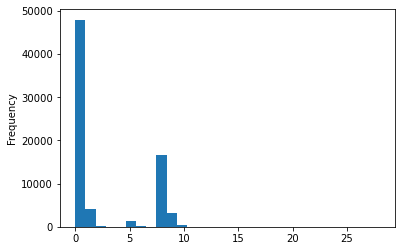

In [12]:
# Explore rows with many NAs

null_count = df.isnull().sum(axis='columns').sort_values(ascending=False)
print(null_count)
null_count.plot.hist(bins=30) # Visualise on a histogram

In [13]:
# Drop rows with more than 7 NA values
df.drop(null_count[null_count > 7].index, inplace=True)
df.shape

(53899, 37)

### 2.2 Cleaning data - data types

### a. Boolean values

In [14]:
# List boolean columns
bools = ['instant_bookable','host_is_superhost']
df.sample(5, random_state=43)[bools]

# Map 't' and 'f' to 'True' and 'False'
map = {'t':True, 'f': False}
for b in bools:
    print(f"Converting {b}")
    df[b] = df[b].replace(map).astype('bool')
    # Same as below
    #df[b] = df[b].replace('t', True).replace('f', False).astype('bool')

# Checking that the type is correctly converted
df[bools].info()

Converting instant_bookable
Converting host_is_superhost
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53899 entries, 0 to 74025
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   instant_bookable   53899 non-null  bool 
 1   host_is_superhost  53899 non-null  bool 
dtypes: bool(2)
memory usage: 526.4 KB


### b. Dates

In [15]:
# List date columns
dates = ['last_scraped','host_since','first_review','last_review']
#df.sample(5, random_state=43)[dates]
df[dates].info()

# Converting from object to datetime
for d in dates:
    print("Converting " + d)
    df[d] = pd.to_datetime(df[d], infer_datetime_format=True)
    
# Checking that the type is correctly converted
print(df[dates[0]].dtype)                                         # Printing data type
df.sample(5, random_state=43)[dates[0]].dt.strftime('%d/%m/%y')   # dt: Accessor object for datetimelike properties

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53899 entries, 0 to 74025
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   last_scraped  53899 non-null  object
 1   host_since    53897 non-null  object
 2   first_review  53899 non-null  object
 3   last_review   53899 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB
Converting last_scraped
Converting host_since
Converting first_review
Converting last_review
datetime64[ns]


36648    27/08/20
61798    27/08/20
7523     26/08/20
55496    27/08/20
38964    24/08/20
Name: last_scraped, dtype: object

### c. Categories

In [16]:
# List category columns
cats = ['property_type','room_type']
#df.sample(5, random_state=43)[cats]
df[cats].info()

# Descriptive statistics on the categories
#print(df[cats[0]].value_counts())
#print(df[cats[1]].value_counts())

# Converting from object to category type
for c in cats:
    print(f"Converting {c}")
    df[c] = df[c].astype('category')

# Checking that the type is correctly converted
df[cats].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53899 entries, 0 to 74025
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   property_type  53899 non-null  object
 1   room_type      53899 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
Converting property_type
Converting room_type
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53899 entries, 0 to 74025
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   property_type  53899 non-null  category
 1   room_type      53899 non-null  category
dtypes: category(2)
memory usage: 529.3 KB


### d. Strings

In [17]:
# List string columns
money = ['price']
df.sample(5, random_state=42)[money]

# Converting from object to float type, after replacing $ and ,
for m in money:
    print(f"Converting {m}")
    df[m] = df[m].str.replace('$', '').str.replace(',', '').astype('float')
    
# Checking
df[money].info()

Converting price
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53899 entries, 0 to 74025
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   53899 non-null  float64
dtypes: float64(1)
memory usage: 842.2 KB


/tmp/ipykernel_1129/296295696.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[m] = df[m].str.replace('$', '').str.replace(',', '').astype('float')


### e. Integers

Float type can cope with NAs, but not the integer type -> Pandas created its own

In [18]:
# List int columns
ints  = ['id','host_id','host_listings_count','host_total_listings_count','accommodates',
         'beds','minimum_nights','maximum_nights','availability_365','calculated_host_listings_count']
df[ints].info()

# Converting to int - if error, convert to UInt16Dtype, which is Pandas integer type that can handle NaNs
for i in ints:
    print(f"Converting {i}")
    try:
        df[i] = df[i].astype('float').astype('int')
    except ValueError as e:
        print("\tConverting to unsigned 16-bit integer.")        #beds have 8 NaNs - so converted to UInt16
        df[i] = df[i].astype('float').astype(pd.UInt16Dtype())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53899 entries, 0 to 74025
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              53899 non-null  float64
 1   host_id                         53899 non-null  float64
 2   host_listings_count             53897 non-null  float64
 3   host_total_listings_count       53897 non-null  object 
 4   accommodates                    53899 non-null  float64
 5   beds                            53673 non-null  float64
 6   minimum_nights                  53899 non-null  float64
 7   maximum_nights                  53899 non-null  object 
 8   availability_365                53899 non-null  float64
 9   calculated_host_listings_count  53899 non-null  float64
dtypes: float64(8), object(2)
memory usage: 4.5+ MB
Converting id
Converting host_id
Converting host_listings_count
	Converting to unsigned 16-bit integer.
Con

## 3. Exploring data

### 3.1 Descriptive statistics

In [19]:
df.describe()

,id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,beds,price,minimum_nights,maximum_nights,availability_365,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,calculated_host_listings_count,reviews_per_month
count,5.389900e+04,5.389900e+04,53897.000000,53897.000000,53899.000000,53899.000000,53899.000000,53673.000000,53899.000000,53899.000000,5.389900e+04,53899.000000,52283.000000,52242.000000,52194.000000,52234.000000,52197.000000,53899.000000,53899.000000
mean,2.328218e+07,8.493381e+07,16.773624,16.773624,51.509589,-0.128711,3.159131,1.729603,109.451192,4.398672,2.932079e+04,125.171858,92.842167,9.277822,9.640744,9.662921,9.551871,12.845210,0.720188
std,1.215981e+07,9.079810e+07,91.286660,91.286660,0.046567,0.093350,1.957706,1.264922,253.819906,18.915354,4.864882e+06,140.388498,10.404253,1.171970,0.923870,0.913548,0.856592,60.408771,0.949448
min,1.155100e+04,2.010000e+03,0.000000,0.000000,51.294790,-0.494850,1.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.010000
25%,1.393803e+07,1.355734e+07,1.000000,1.000000,51.484440,-0.188920,2.000000,1.000000,44.000000,1.000000,3.100000e+01,0.000000,90.000000,9.000000,10.000000,10.000000,9.000000,1.000000,0.140000
50%,2.332139e+07,4.397631e+07,1.000000,1.000000,51.513880,-0.125660,2.000000,1.000000,76.000000,2.000000,1.125000e+03,73.000000,96.000000,10.000000,10.000000,10.000000,10.000000,1.000000,0.380000
75%,3.382816e+07,1.383734e+08,4.000000,4.000000,51.538005,-0.070440,4.000000,2.000000,123.000000,3.000000,1.125000e+03,249.000000,100.000000,10.000000,10.000000,10.000000,10.000000,4.000000,0.940000
max,4.501662e+07,3.629385e+08,1111.000000,1111.000000,51.681690,0.268950,16.000000,28.000000,18638.000000,1124.000000,1.000000e+09,365.000000,100.000000,10.000000,10.000000,10.000000,10.000000,718.000000,20.000000


In [20]:
df[['price','longitude','latitude']].describe(percentiles=[0.01, 0.99])

,price,longitude,latitude
count,53899.000000,53899.000000,53899.000000
mean,109.451192,-0.128711,51.509589
std,253.819906,0.093350,0.046567
min,0.000000,-0.494850,51.294790
1%,19.000000,-0.395112,51.380499
50%,76.000000,-0.125660,51.513880
99%,578.020000,0.109701,51.619141
max,18638.000000,0.268950,51.681690


### *Saving data*

In [21]:
path = os.path.join('data','clean')
fn_clean   = fn.split('.')[-3] + '_clean.csv'   # New file name with _clean

# Saving the clean data as a csv
if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
df.to_csv(os.path.join(path,fn_clean), index=False)
print(f"Cleaned data saved as {fn_clean}.")

Cleaned data saved as 2020-08-24-listings_clean.csv.


### 3.2 Selecting entries with conditions

In [22]:
# Check out the data with groupby function
df.groupby('room_type')['property_type'].value_counts()

room_type                                 
Entire home/apt  Entire apartment             24164
                 Entire house                  3630
                 Entire condominium             849
                 Entire townhouse               810
                 Entire serviced apartment      484
                                              ...  
Shared room      Private room in apartment        0
                 Private room                     0
                 Lighthouse                       0
                 Hut                              0
                 Yurt                             0
Name: property_type, Length: 332, dtype: int64

In [23]:
# Filtering with range
df_pricey = df[(df['room_type'] =='Entire home/apt') & (df['price'] > 100)]
print(f"Selected {df_pricey.shape[0]} rows")

Selected 16590 rows


In [24]:
# Filtering with min/ max
df[df.price==df.price.min()][['price','id','listing_url','room_type','description']]
#df[df.price==df.price.max()][['price','id','listing_url','room_type','description']]

,price,id,listing_url,room_type,description
60153,0.0,39339578,https://www.airbnb.com/rooms/39339578,Private room,Live canal side in a private development in tr...
60590,0.0,39546721,https://www.airbnb.com/rooms/39546721,Private room,Panoramic 9th floor skyline view. Private Balc...


In [25]:
# Filtering with range (e.g. 25 percentile~ 75 percentile)
df_mid50 = df[ (df.price > df.price.quantile(0.25)) & (df.price < df.price.quantile(0.75)) ]

print(f"Rows: {df_mid50.shape[0]}")
print(f"Lower Quartile: {df_mid50.price.min():.2f}")  # 2 decimal place
print(f"Upper Quartile: {df_mid50.price.max():.2f}")

df_mid50.head(3)

Rows: 26912
Lower Quartile: 44.29
Upper Quartile: 122.86


,id,listing_url,last_scraped,name,description,host_id,host_name,host_since,host_location,host_is_superhost,...,first_review,last_review,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,instant_bookable,calculated_host_listings_count,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,2020-08-26,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,43039,Adriano,2009-10-03,"London, England, United Kingdom",False,...,2010-03-21,2020-03-26,91.0,9.0,10.0,10.0,9.0,True,2,1.51
1,13913,https://www.airbnb.com/rooms/13913,2020-08-27,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,54730,Alina,2009-11-16,"London, England, United Kingdom",False,...,2010-08-18,2020-02-22,97.0,10.0,10.0,10.0,9.0,False,3,0.17
2,15400,https://www.airbnb.com/rooms/15400,2020-08-26,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,60302,Philippa,2009-12-05,"Kensington, England, United Kingdom",False,...,2009-12-21,2020-03-16,96.0,10.0,10.0,10.0,10.0,True,1,0.68


### 3.3 Creating new columns

In [26]:
# Z score
df['z_score_price'] = (df.price - df.price.mean()) / df.price.std()
df.columns    # 'z' is added at the end

Index(['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id',
       'host_name', 'host_since', 'host_location', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'availability_365', 'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'instant_bookable',
       'calculated_host_listings_count', 'reviews_per_month', 'z_score_price'],
      dtype='object')

In [27]:
# IQR-standardised score, given by iqs = (x - Q2)/(Q3 - Q1)
df['iqr_standardised_price'] = (df.price - df.price.quantile(0.25))/(df.price.quantile(0.75)-df.price.quantile(0.25))
df.iqr_standardised_price.describe()

count    53899.000000
mean         0.828496
std          3.212910
min         -0.556962
25%          0.000000
50%          0.405063
75%          1.000000
max        235.367089
Name: iqr_standardised_price, dtype: float64

In [38]:
# Log(price)
df = df[df.price != 0]
df['ln_price'] = np.log(df.price)
df.ln_price.describe()

count    53897.000000
mean         4.341716
std          0.755946
min          2.079442
25%          3.784190
50%          4.330733
75%          4.812184
max          9.832958
Name: ln_price, dtype: float64

### 3.4 Quick visualisation

Quick plots with `DataFrame.Series.plot.<plot type>`

<AxesSubplot:ylabel='Frequency'>

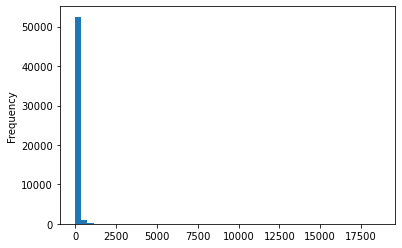

In [39]:
df.price.plot.hist(bins=50) # histogram

<AxesSubplot:ylabel='Density'>

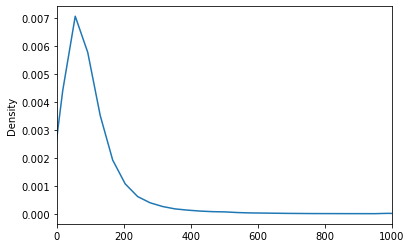

In [40]:
df.price.plot.kde(xlim=(0,1000)) #kernel density estimate plot

<AxesSubplot:ylabel='Density'>

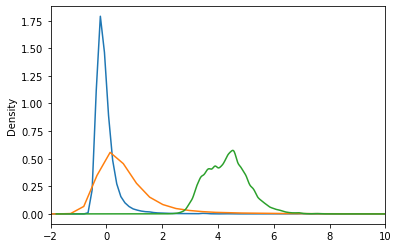

In [41]:
# Overlays graphis if called together
df.z_score_price.plot.kde(xlim=[-2, 10])
df.iqr_standardised_price.plot.kde(xlim=[-2, 10])
df.ln_price.plot.kde()

<AxesSubplot:>

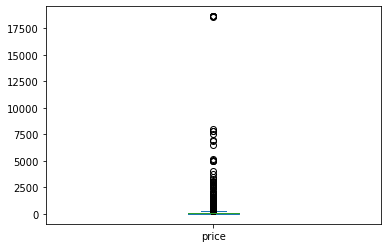

In [42]:
df.price.plot.box() # boxplot

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

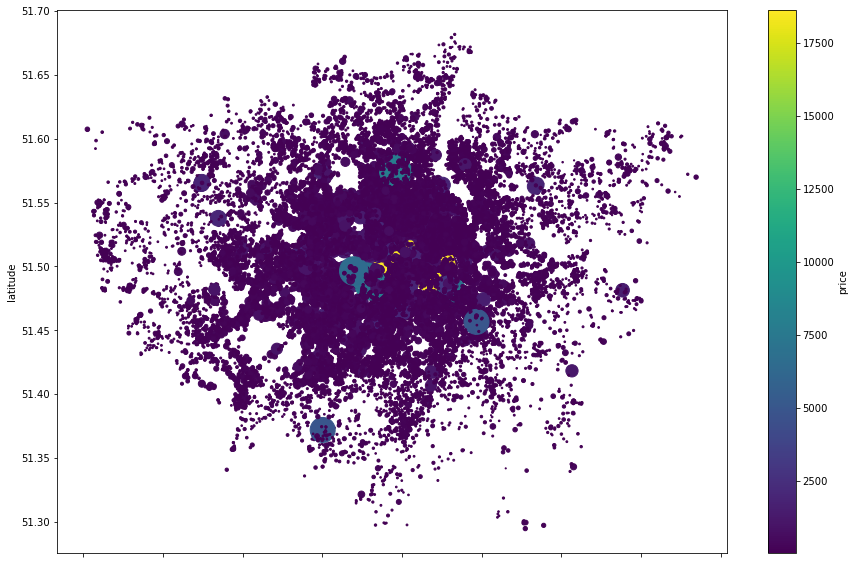

In [43]:
# Scatter plot - c: color variation; s: size
df.plot.scatter(x='longitude', y='latitude', c='price', s=(df.price/df.price.min()), cmap='viridis', figsize=(15,10))

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

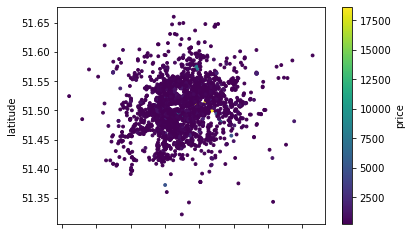

In [44]:
# Mapping selected points - expensive 10% (note: cannot use size attribute)
df[df.price > df.price.quantile(0.90)].plot.scatter(x='longitude', y='latitude', c='price', cmap='viridis', s=8)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

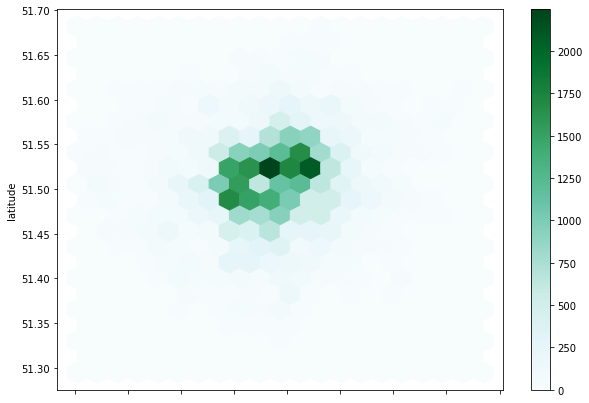

In [45]:
df.plot.hexbin(x='longitude', y='latitude', gridsize=20, figsize=(10,7))  #hex bin plot

# Practical 7 Spatial data (Geopandas)

## 4. Setting up geo data

### 4.1 Loading data (gpkg)

In [46]:
ddir  = os.path.join('data','raw') # destination directory
spath = 'https://github.com/jreades/i2p/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

Found data/raw/Boroughs.gpkg locally!


/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Found data/raw/Water.gpkg locally!
Found data/raw/Greenspace.gpkg locally!
Done.


### 4.2 Checking data

In [47]:
list = [boros, water, green]
#for file in list:
#    print(file.crs)    # Printing CRS
#    print(file.plot()) # Mapping data

For more mapping styles, see: https://geopandas.org/en/stable/docs/user_guide/mapping.html
For more map colours, see: https://matplotlib.org/3.1.1/tutorials/colors/colors.html#specifying-colors

In [48]:
#boros.plot(edgecolor = "red", facecolor = "white", linewidth = 2)
#water.plot(facecolor = 'xkcd:light blue')
#green.plot(facecolor = (0,1,0), alpha = 0.5)    # with RGB colour coding

Mapping above in the same plot:
1. Write the code to plot every image on the same set of axes by defining shared axis, 'ax'
2. Set plot range for London: Easting range 501,000 to 563,000 and the Northing range 155,000 to 202,000
3. Plot 3 maps as layers
4. Save it somewhere local

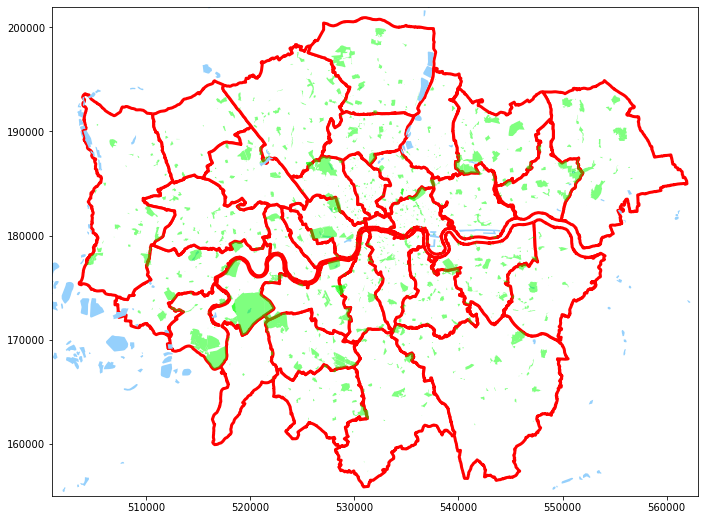

In [49]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

# Plot all three to the same axes
boros.plot(ax=ax, edgecolor = "red", facecolor = "white", linewidth = 3)
water.plot(ax=ax, facecolor = 'xkcd:light blue')
green.plot(ax=ax, facecolor = (0,1,0), alpha = 0.5)

# Set the limits
ax.set_xlim([501000, 563000])
ax.set_ylim([155000, 202000])

#save
fig.savefig(os.path.join("output", "London_subplot_map.png"))

### 4.3 Converting CSV data to geo data

First, remove data without the location data

In [50]:
df.drop(df[df["latitude"].isna()].index.values, axis = 0, inplace = True)
df.drop(df[df["longitude"].isna()].index.values, axis = 0, inplace = True)
print(f"df now contains {df.shape[0]} rows.")

df now contains 53897 rows.


Inspecting location range

In [52]:
print(f"The bottom-left corner is {df.longitude.min()}, {df.latitude.min()}")
print(f"The top-right corner is {df.longitude.max()}, {df.latitude.max()}")

The bottom-left corner is -0.49485, 51.29479
The top-right corner is 0.26895, 51.68169


Converting csv data points to location objects using `points_from_xy`

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>
POINT (-0.1112099999999999 51.56802)


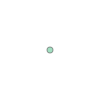

In [53]:
#gdf: geopandas dataframe
gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs='epsg:4326'))
                       
print(type(gdf))            # geodataframe: GeoDataFrame
print(type(gdf.geometry))   # geometry: GeoSeries
print(gdf.geometry.iloc[1]) # contents of geometry: point
gdf.geometry.iloc[1]        # Printing a point

### 4.4 Saving the converted geodata

GeoPandas has a function to save files locally (to_file), which requires a driver specified

MULTIPOLYGON (((535009.2 159504.7, 535005.5 159502, 535002.9 159500.1, 535000.1 159503.2, 535000 159503.2, 534747.8 159517.8, 534588 159522.1, 534512.3 159780.5, 534474.8 159760.8, 534398.8 159726.7, 534391.9 159723.3, 534378.9 159712.4, 534345.1 159702.8, 534314.3 159691.8, 534292.7 159683.9, 534253.1 159666.6, 534229.4 159657.9, 534207.5 159654.6, 534160.5 159651.5, 534159.7 159637.1, 534109.5 ...


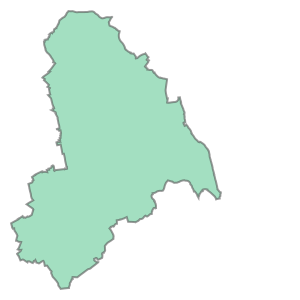

In [54]:
print(str(boros.geometry.iloc[1])[:399] + "...") # Object to string then print out first 399 characters
boros.geometry.iloc[1] # So this is a multi-polygon boundary

In [55]:
boros.to_file(os.path.join("output","boro.gpkg"), driver = "GPKG") 

## 5. Mapping

### 5.1 Reprojection

In [56]:
print(gdf.geometry.crs)
print(gdf.total_bounds)
#gdf.plot(figsize=(12,8), marker='*', color='green', markersize=0.25)

epsg:4326
[-0.49485 51.29479  0.26895 51.68169]


In [57]:
# Reprojecting to British National Grid
gdf.to_crs("EPSG:27700", inplace = True)

Note that a geopandas dataframe is also a pandas dataframe, so all functions that work for pandas can also be used on geopandas (e.g. creating boxplots)

### 5.2 Choropleth Mapping

<AxesSubplot:>

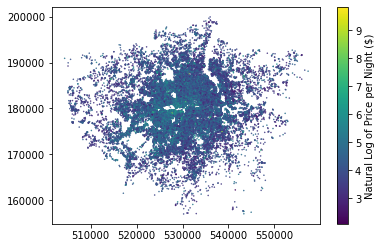

In [58]:
# Mapping logged price
gdf.plot(column='ln_price', cmap='viridis', figsize = (6, 4),legend = True, 
         legend_kwds = {"label": "Natural Log of Price per Night ($)"}, markersize = 0.25) #kwds: keywords

(178000.0, 185000.0)

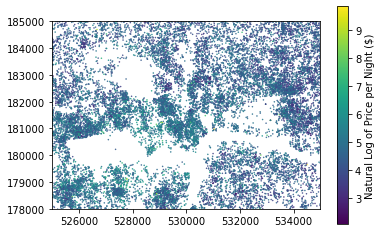

In [59]:
# To zoom in/ out, set map limits
ax = gdf.plot(column='ln_price', cmap='viridis', figsize = (6, 4),legend = True, 
         legend_kwds = {"label": "Natural Log of Price per Night ($)"}, markersize = 0.25)
ax.set_xlim([525000,535000])
ax.set_ylim([178000,185000])

(155000.0, 202000.0)

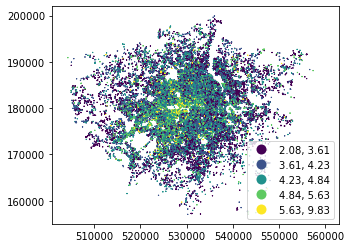

In [60]:
# Using Fisher Jenks break (there other many others, such as quantile)

ax = gdf.plot(figsize=(6,4), marker='*', markersize=0.25, 
         column='ln_price', cmap='viridis', scheme='fisher_jenks', k=5, 
         legend=True)
ax.set_xlim([501000, 563000])
ax.set_ylim([155000, 202000])

### 5.3 Mapping together

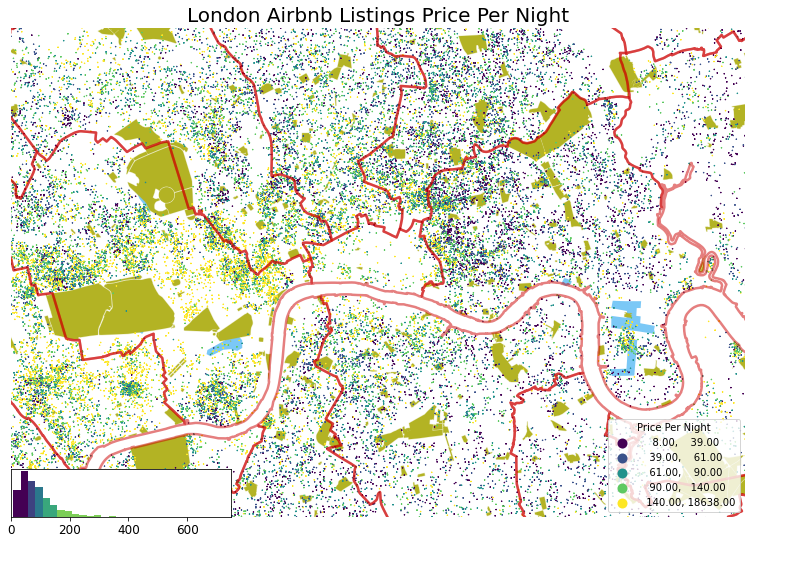

In [61]:
import legendgram
import pysal as p
import mapclassify as mc
import palettable.matplotlib as palmpl
from legendgram import legendgram

q = mc.Quantiles(gdf.price.values, k=5) # For Fisher Jenks you may want 'Sampled' to speed things up

f,ax = plt.subplots(figsize=(15,9))
water.plot(edgecolor="none", facecolor='xkcd:lightblue', ax=ax)
green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14), ax=ax)
gdf.plot(column='price', scheme='Quantiles', k=5, 
         cmap='viridis', legend=True, marker='*', markersize=0.5, ax=ax)
boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=2.5, ax=ax)

ax.set_xlim([525000,540000])
ax.set_ylim([176000,186000])
ax.axis('off') #don't plot the axes (bounding box)
ax.set_title('London Airbnb Listings Price Per Night', fontdict={'fontsize':'20', 'fontweight':'3'})  #provide a title
a = ax.annotate('Source: InsideAirbnb (2020)',
             xy=(0.905, 0.055), xycoords='figure fraction', 
             horizontalalignment='right', verticalalignment='bottom', 
             fontsize=12, fontweight=4, color='#555555')  #add source info on the image itself
a.set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='white'))
ax.get_legend().set_title("Price Per Night")  #set the legend title

legendgram(f, ax, 
            gdf.price, q.bins, bins=round(gdf.price.max()/25),
            pal=palmpl.Viridis_5,
            legend_size=(0.3, 0.1), 
            loc='lower left',
            clip=(0,750),
            frameon=True
    )

f.savefig(os.path.join('output','map_together.png'), dpi=150)

### 5.4 Adding basemap (optional)

1. Calculate the bounds of the map using the min/max x and y coordinates.
2. Calculate the centroid of the map from the bounds.
3. Set an appropriate zoom level.

Basemap patterns can be found here: https://ipyleaflet.readthedocs.io/en/latest/api_reference/basemaps.html

In [62]:
# Calculating the map bounds and the centroid

from math import floor, ceil

# Calculate min and max to two decimal points
xmin = floor(gdf.longitude.min() * 100)/100.0 #minimum -> floor
xmax = ceil(gdf.longitude.max() * 100)/100.0 #maximum -> ceil
ymin = floor(gdf.latitude.min() * 100)/100.0
ymax = ceil(gdf.latitude.max() * 100)/100.0

print(xmin, xmax, ymin, ymax)

# Calculate the centre of the map
yctr = (ymin+ymax)/2
xctr = (xmin+xmax)/2

print(xctr, yctr)

-0.5 0.27 51.29 51.69
-0.11499999999999999 51.489999999999995


In [63]:
# Displaying the basemap

from ipyleaflet import Map, basemaps, basemap_to_tiles, Rectangle, projections

watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)
m = Map(layers=(watercolor, ), center=(yctr, xctr), zoom=8)    # Basemap m
rectangle = Rectangle(bounds=( (ymin, xmin), (ymax, xmax) ),   # Adding a rectangle bound to the basemap
    crs=projections.EPSG4326
)
m.add_layer(rectangle)

m

Map(center=[51.489999999999995, -0.11499999999999999], controls=(ZoomControl(options=['position', 'zoom_in_tex…

# Practical 7 Textual Data

## 

# Practical 8 Visualising Data

## 6 Visualisation with maps

### 6.1 Setting up shapefile

Found data/raw/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip locally!


<AxesSubplot:>

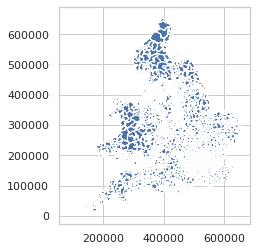

In [180]:
# MSOAs

ddir  = os.path.join('data','raw') # destination directory
url = 'https://github.com/jreades/i2p/blob/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true' # source path
fn  = os.path.split(url)[-1]

msoas = gpd.read_file(cache_data(url, ddir))
msoas.plot()

Found data/raw/Boroughs.gpkg locally!


/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

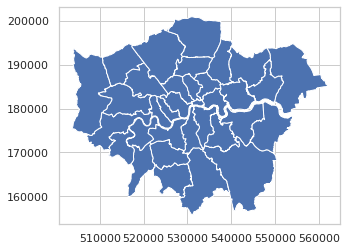

In [181]:
# Boroughs

ddir  = os.path.join('data','raw') # destination directory
url = 'https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true' # source path
fn  = os.path.split(url)[-1]

boros = gpd.read_file(cache_data(url, ddir))
boros.plot()

,original,geometry
0,"POLYGON ((534747.800 159517.800, 534588.000 15...","POLYGON ((503325.036 175328.990, 503324.758 17..."


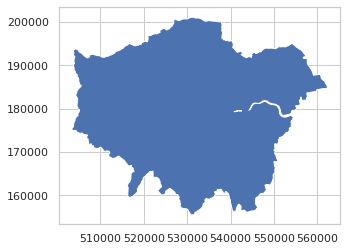

In [182]:
# Get outline of London using the `unary_union` operator

# Extracting the geometry column with column name 'original'
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})

# In order to ensure that we get all MSOAs are included, add buffer of 250m and save as column name 'geometry'
ldn['geometry'] = ldn.original.buffer(250)
ldn = ldn.set_geometry('geometry')
ldn.plot()

ldn

Extracting MSOAs within London - spatial join

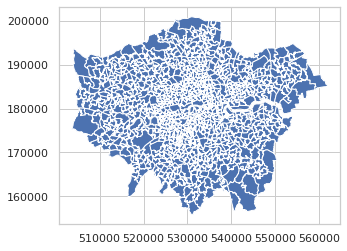

In [183]:
ldn_msoas = gpd.sjoin(msoas, ldn, op='within')   # default: inner join
ldn_msoas.plot();

del(msoas)  # delete the remaining msoas data

In [184]:
ldn_msoas.sample(3)

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry,index_right,original
346,347,E02000361,Hackney 017,Hackney 017,534917,184950,-0.05563,51.54732,5.931978e+05,6456.839292,"POLYGON ((535368.464 185567.939, 535387.625 18...",0,"POLYGON ((534747.800 159517.800, 534588.000 15..."
6783,6784,E02006927,Greenwich 034,Greenwich 034,540765,175168,0.02475,51.45799,2.526112e+06,8592.913078,"POLYGON ((541029.881 176265.023, 541101.997 17...",0,"POLYGON ((534747.800 159517.800, 534588.000 15..."
199,200,E02000206,Croydon 013,Croydon 013,533077,167349,-0.08877,51.38958,1.466168e+06,6811.671223,"POLYGON ((533520.909 168175.562, 533580.606 16...",0,"POLYGON ((534747.800 159517.800, 534588.000 15..."


Creating **borough name** entry to the ldn_msoas dataframe

In [185]:
ldn_msoas['Borough'] = ldn_msoas.MSOA11NM.str.replace(r'\s\d+$','',regex=True)

print(ldn_msoas.Borough.unique())
print(len(ldn_msoas.Borough.unique()))
print(ldn_msoas.shape)

['City of London' 'Barking and Dagenham' 'Barnet' 'Bexley' 'Brent'
 'Bromley' 'Camden' 'Croydon' 'Ealing' 'Enfield' 'Greenwich' 'Hackney'
 'Hammersmith and Fulham' 'Haringey' 'Harrow' 'Havering' 'Hillingdon'
 'Hounslow' 'Islington' 'Kensington and Chelsea' 'Kingston upon Thames'
 'Lambeth' 'Lewisham' 'Merton' 'Newham' 'Redbridge' 'Richmond upon Thames'
 'Southwark' 'Sutton' 'Tower Hamlets' 'Waltham Forest' 'Wandsworth'
 'Westminster']
33
(983, 14)


Creating **MSOA name** entry to the ldn_msoas dataframe

In [186]:
# Saving and loading the MSOA name data

ddir  = os.path.join('data','raw') # destination directory
url = 'https://github.com/jreades/i2p/blob/master/data/src/MSOA-Names-1.8.csv.gz?raw=true' # source path
fn  = os.path.split(url)[-1]

msoa_nms = pd.read_csv(cache_data(url, ddir), compression='gzip')


Found data/raw/MSOA-Names-1.8.csv.gz locally!


In [187]:
print(msoa_nms.columns.values)
msoa_nms.sample(3, random_state=42)

['msoa11cd' 'msoa11nm' 'msoa11nmw' 'msoa11hclnm' 'msoa11hclnmw' 'Laname']


,msoa11cd,msoa11nm,msoa11nmw,msoa11hclnm,msoa11hclnmw,Laname
4512,E02005951,Oxford 012,Oxford 012,Grandpont & New Hinksey,NaN,Oxford
4660,W02000113,Powys 017,Powys 017,Brecon,Aberhonddu,Powys
1038,W02000309,Caerphilly 020,Caerffili 020,Bedwas & Trethomas,Bedwas a Thretomas,Caerphilly


In [188]:
msoas = pd.merge(ldn_msoas, msoa_nms, left_on='MSOA11CD', right_on='msoa11cd', how='inner')
print(msoas.shape)
print(type(msoas)) # You should check this -- result isn't always be a GeoDataFrame
msoas.sample(3, random_state=42)[['OBJECTID','MSOA11CD','MSOA11NM','msoa11hclnm']]

(983, 20)
<class 'geopandas.geodataframe.GeoDataFrame'>


,OBJECTID,MSOA11CD,MSOA11NM,msoa11hclnm
810,811,E02000841,Sutton 002,St Helier South
801,802,E02000832,Southwark 026,Nunhead North
813,814,E02000844,Sutton 005,The Wrythe


In [189]:
# Removing unnecessary columns
to_drop = ['MSOA11NMW','LONG','LAT','Shape__Are','Shape__Len','index_right',
           'original','msoa11cd','msoa11nm','msoa11nmw','Laname','msoa11hclnmw']
msoas.drop(columns=to_drop, inplace=True)
print(msoas.shape)

(983, 8)


In [190]:
# Save the new dataframe

msoas.to_file(os.path.join('data','clean','London_MSOAs.gpkg'), driver='GPKG')

### 6.2 Combining shapefile and Airbnb data

In [191]:
# Adding Local Authority name to the Airbnb data
gdf_la = gpd.sjoin(gdf, boros, op='within', how='left') # op options: intersect, within, contains

# Dropping columns that are not necessary
gdf_la.drop(columns=['index_right','HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)
gdf_la.columns

Index(['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id',
       'host_name', 'host_since', 'host_location', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'availability_365', 'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'instant_bookable',
       'calculated_host_listings_count', 'reviews_per_month', 'z_score_price',
       'iqr_standardised_price', 'ln_price', 'geometry', 'NAME', 'GSS_CODE'],
      dtype='object')

['Lambeth' 'Islington' 'Kensington and Chelsea' 'Westminster' 'Barnet'
 'Hounslow' 'Richmond upon Thames' 'Haringey' 'Hackney' 'Southwark'
 'Tower Hamlets' 'Hammersmith and Fulham' 'Waltham Forest' 'Brent'
 'Camden' 'Croydon' 'Merton' 'Wandsworth' 'Bromley' 'Greenwich' 'Lewisham'
 'Ealing' 'Newham' 'Enfield' 'City of London' 'Barking and Dagenham'
 'Hillingdon' 'Harrow' 'Redbridge' 'Kingston upon Thames' 'Havering'
 'Bexley' 'Sutton' nan]
             id                                               name
24473  18841368  Luxury Double Room, King Size Bed near to 02 A...
70891  43724271               Close to the river - a private space
70954  43755065  Cosy friendly house set in a peaceful environm...
71216  43894894                         Greenwich Home with a View
72350  44273549           Exclusive Bright Studio - Central London
72792  44429466                              Panoramic river views


<AxesSubplot:>

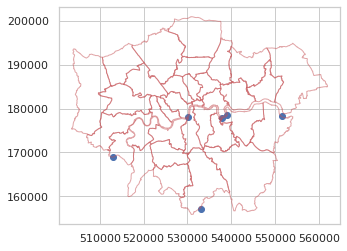

In [192]:
# Some names are nan - investigate why
print(gdf_la.NAME.unique())
print(gdf[gdf_la.NAME.isna()][['id','name']])

# Map those entries
ax = gdf_la[gdf_la.NAME.isna()].plot()
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5)

In [193]:
# Drop these entries
gdf_la.drop(index=gdf[gdf_la.NAME.isna()].index, axis=1, inplace=True)
print(gdf_la.shape)

(53891, 43)


### 6.3 Visualising the results

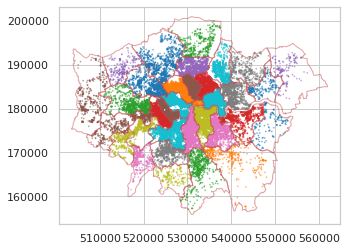

In [194]:
# Airbnb entries with LA colour scheme
ax = gdf_la.plot(column='NAME', markersize=0.5, alpha=0.5, figsize=(8,4))
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5);

(0.0, 500.0)

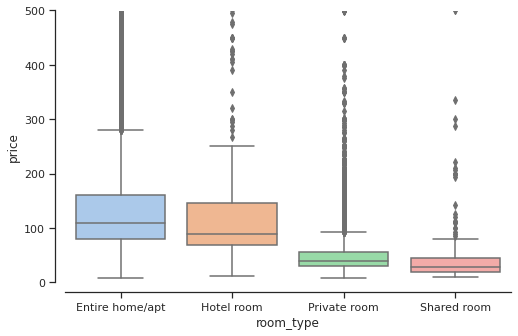

In [195]:
# Seaborn boxplot - price range for each room type
sns.set_style('whitegrid')
sns.set_theme(style="ticks", palette="pastel")
f,ax = plt.subplots(figsize=(8,5))                # Setting the axis
sns.boxplot(y=gdf_la.price, x=gdf_la.room_type)   # Plotting
sns.despine(offset = 10)                          # Adding bottom spacing
ax.set_ylim([0,500])

In [196]:
# Group the data by MSOA
la_data = gdf_la.groupby(['NAME'])
print(type(la_data))
la_data.price.mean()

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


NAME
Barking and Dagenham       55.523810
Barnet                     77.682266
Bexley                     67.360248
Brent                      87.590689
Bromley                    68.664303
Camden                    124.947365
City of London            219.538836
Croydon                    55.348352
Ealing                     76.962103
Enfield                    66.794617
Greenwich                  82.561316
Hackney                    87.073971
Hammersmith and Fulham    122.393939
Haringey                   86.521607
Harrow                     83.097473
Havering                   65.435294
Hillingdon                 55.900138
Hounslow                   84.561849
Islington                 117.888216
Kensington and Chelsea    173.903372
Kingston upon Thames       77.769295
Lambeth                    90.438526
Lewisham                   78.925462
Merton                     91.853264
Newham                     77.494980
Redbridge                  75.575659
Richmond upon Thames      108.296

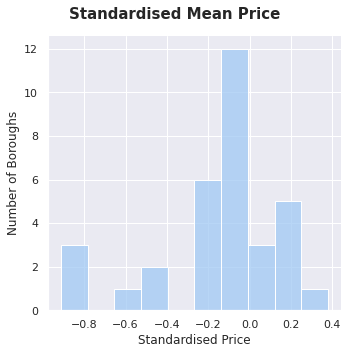

In [197]:
# Seaborn displot with data grouped by MSOA
sns.set_style('darkgrid')
ax = sns.displot((la_data.price.mean() - la_data.price.mean().mean())/la_data.price.std())
ax.set(xlabel='Standardised Price', ylabel='Number of Boroughs')
plt.gcf().subplots_adjust(top=0.9)
plt.gcf().suptitle('Standardised Mean Price', fontsize=15, fontweight='bold');

In [198]:
# Group by both MSOA and room type columns with agg
la_data2 = gdf_la.groupby(['NAME','room_type']).agg(
    {'price':['count','sum','mean','median','std',lambda x: x.quantile(0.25),lambda x: x.quantile(0.75)]}
).reset_index()
la_data2.sample(3, random_state=42)

NAME        room_type price                              \
                                          count      sum        mean median   
56                Harrow  Entire home/apt    98  15728.0  160.489796   85.0   
83  Kingston upon Thames      Shared room     1     17.0   17.000000   17.0   
19               Bromley      Shared room     3    169.0   56.333333   50.0   

                                      
           std <lambda_0> <lambda_1>  
56  317.503608       62.5      126.0  
83         NaN       17.0       17.0  
19   10.969655       50.0       59.5

In [199]:
la_data2.columns = la_data2.columns.droplevel(0)
print(la_data2.columns.values)

['' '' 'count' 'sum' 'mean' 'median' 'std' '<lambda_0>' '<lambda_1>']


In [200]:
# Renaming the columns
cols = la_data2.columns.values
cols[ 0] = 'name'
cols[ 1] = 'room_type'
cols[-2] = 'lq'
cols[-1] = 'uq'
la_data2.columns = cols

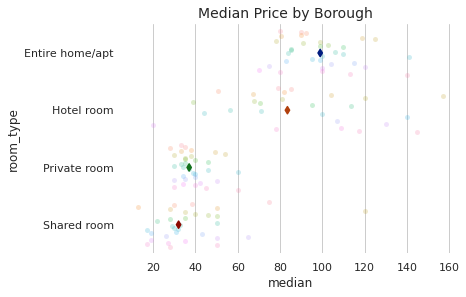

In [201]:
# Show median for room type - borough

sns.set_theme(style="whitegrid")

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
# https://seaborn.pydata.org/examples/jitter_stripplot.html
g = sns.stripplot(x="median", y="room_type", hue="name",
              data=la_data2, dodge=True, alpha=.25, zorder=1)
g.legend_.remove()

# Show the median of medians
sns.pointplot(x="median", y="room_type",
              data=la_data2.groupby('room_type').agg('median').reset_index(), 
              dodge=.232, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

plt.gcf().subplots_adjust(top=0.92)
f.suptitle('Median Price by Borough', fontsize=14);

In [202]:
# Group by borough category and repeat above

mapping = {}
for b in ['Enfield','Waltham Forest','Redbridge','Barking and Dagenham','Havering','Greenwich','Bexley']:
    mapping[b]='Outer East and North East'
for b in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham']:
    mapping[b]='Inner East'
for b in ['Bromley','Croydon','Sutton','Merton','Kingston upon Thames']:
    mapping[b]='Outer South'
for b in ['Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden']:
    mapping[b]='Inner West'
for b in ['Richmond upon Thames','Hounslow','Ealing','Hillingdon','Brent','Harrow','Barnet','City of London']:
    mapping[b]='Outer West and North West'
mapping

{'Enfield': 'Outer East and North East',
 'Waltham Forest': 'Outer East and North East',
 'Redbridge': 'Outer East and North East',
 'Barking and Dagenham': 'Outer East and North East',
 'Havering': 'Outer East and North East',
 'Greenwich': 'Outer East and North East',
 'Bexley': 'Outer East and North East',
 'Haringey': 'Inner East',
 'Islington': 'Inner East',
 'Hackney': 'Inner East',
 'Tower Hamlets': 'Inner East',
 'Newham': 'Inner East',
 'Lambeth': 'Inner East',
 'Southwark': 'Inner East',
 'Lewisham': 'Inner East',
 'Bromley': 'Outer South',
 'Croydon': 'Outer South',
 'Sutton': 'Outer South',
 'Merton': 'Outer South',
 'Kingston upon Thames': 'Outer South',
 'Wandsworth': 'Inner West',
 'Kensington and Chelsea': 'Inner West',
 'Hammersmith and Fulham': 'Inner West',
 'Westminster': 'Inner West',
 'Camden': 'Inner West',
 'Richmond upon Thames': 'Outer West and North West',
 'Hounslow': 'Outer West and North West',
 'Ealing': 'Outer West and North West',
 'Hillingdon': 'Outer 

In [203]:
la_data3 = gdf_la.set_index('NAME').groupby([mapping,'room_type']).agg(
    {'price':['mean','median']}
).reset_index()

la_data3.sample(3)

NAME        room_type       price       
                                                      mean median
1                  Inner East       Hotel room   85.718194   72.0
16  Outer West and North West  Entire home/apt  139.143939  100.0
8   Outer East and North East  Entire home/apt  111.241703   90.0

In [204]:
la_data3.columns = la_data3.columns.droplevel(0)
cols = la_data3.columns.values
cols[0]  = 'area'
cols[1]  = 'room_type'
la_data3.columns = cols

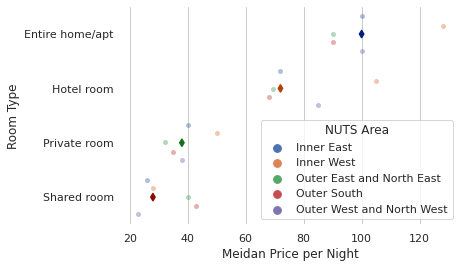

In [205]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
# https://seaborn.pydata.org/examples/jitter_stripplot.html
g = sns.stripplot(x="median", y="room_type", hue="area",
              data=la_data3, dodge=True, alpha=.45, zorder=1)
g.legend_.set_title('NUTS Area')

# Show the median of medians
sns.pointplot(x="median", y="room_type",
              data=la_data3.groupby('room_type').agg('median').reset_index(), 
              join=False, palette="dark",
              markers="d", scale=.75, ci=None)

# See if you can work out how to set the plot x- and y-labels...
plt.xlabel('Meidan Price per Night')
plt.ylabel('Room Type');

### 6.4 Visualising the results - area deep dive

In [206]:
# Explore Waltham Forest in more details
LA = 'Waltham Forest'

msoa_WF  = gpd.sjoin(
            gdf_la[gdf_la.NAME==LA].reset_index(), 
            msoas[msoas.Borough==LA], op='within')

In [207]:
msoa_WF_agg = msoa_WF.groupby('MSOA11NM').agg({'price':['median','count']}).reset_index()
msoa_WF_agg.head()

MSOA11NM  price      
                      median count
0  Waltham Forest 001   52.0     9
1  Waltham Forest 002   50.0    16
2  Waltham Forest 003   56.0     5
3  Waltham Forest 004   45.0     7
4  Waltham Forest 005   29.0     8

In [208]:
msoa_WF_agg.columns = msoa_WF_agg.columns.get_level_values(1)
msoa_WF_agg.head()

,,median,count
0,Waltham Forest 001,52.0,9
1,Waltham Forest 002,50.0,16
2,Waltham Forest 003,56.0,5
3,Waltham Forest 004,45.0,7
4,Waltham Forest 005,29.0,8


In [209]:
msoa_WF_agg.rename(columns={'':'MSOA11NM', 'count':'listings'}, inplace=True)

In [210]:
# Join the MSOA level Airbnb data with MSOA data 

msoa_gdf = msoa_WF_agg.set_index('MSOA11NM').join(
                msoas[msoas.Borough==LA].set_index('MSOA11NM'), 
                rsuffix='_r')  # no need as there is no overlapping column names in this cases
msoa_gdf.head(3)

,median,listings,OBJECTID,MSOA11CD,BNG_E,BNG_N,geometry,Borough,msoa11hclnm
MSOA11NM,,,,,,,,,
Waltham Forest 001,52.0,9,863,E02000895,537936,194880,"POLYGON ((537919.442 195742.428, 538051.250 19...",Waltham Forest,Chingford Green West
Waltham Forest 002,50.0,16,864,E02000896,539350,194516,"POLYGON ((539172.688 195540.000, 539696.813 19...",Waltham Forest,Chingford Green East
Waltham Forest 003,56.0,5,865,E02000897,539355,193522,"POLYGON ((538862.624 194017.438, 539001.125 19...",Waltham Forest,Friday Hill


In [211]:
# This gives an error as msoa_gdf has not been recognised as geodataframe yet
#msoa_gdf.plot(column='median', legend=True)
type(msoa_gdf)

pandas.core.frame.DataFrame

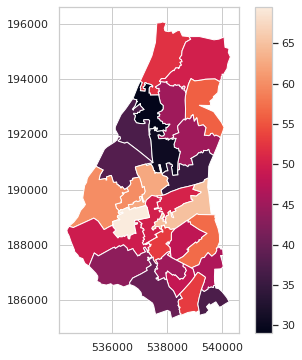

In [212]:
msoa_gdf = msoa_gdf.set_geometry('geometry')                 # Now a geopandas dataframe
msoa_gdf.plot(column='median', legend=True, figsize=(6,6));

### 6.5 Inset map (QGIS Atlas type)

In [213]:
# Setting the title font
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

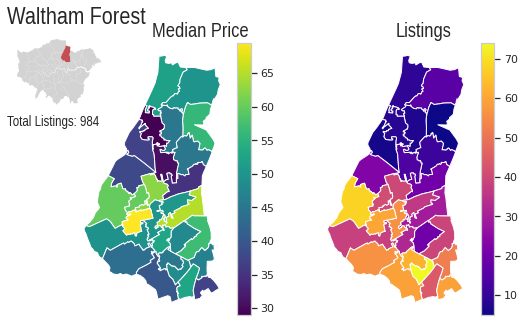

In [214]:
f,axes = plt.subplots(1,2,figsize=(8,5))

msoa_gdf.plot(column='median', ax=axes[0], legend=True, cmap='viridis')
msoa_gdf.copy().plot(column='listings', ax=axes[1], legend=True, cmap='plasma')
for ax in axes:
    ax.axis('off')
    
ax2 = f.add_axes([0.015, 0.7, 0.2, 0.2])
boros.plot(facecolor='lightgrey', edgecolor='None', ax=ax2)
boros[boros.NAME==LA].plot(facecolor='r', edgecolor='r', hatch='///', ax=ax2)
ax2.axis('off')

f.suptitle(LA, x=0.025, ha='left', size=24, **tfont)
axes[0].set_title('Median Price', size=20, **tfont)
axes[1].set_title('Listings', size=20, **tfont)

plt.figtext(x=0.025, y=0.65, s=f"Total Listings: {msoa_gdf.listings.sum():,.0f}", size=14, **tfont);

### 6.6 Advanced mapping with Bokeh (optional) - more details in practical 8 notebook

In [215]:
LA = 'Camden'

la_rt = gdf_la.groupby(['NAME','room_type']).agg({'price':['median','count']}).reset_index()
la_rt.columns = ['NAME','room_type','price','listings']
la_rt.head()

la_rt[la_rt.NAME==LA]

,NAME,room_type,price,listings
20,Camden,Entire home/apt,119.0,2626
21,Camden,Hotel room,104.0,42
22,Camden,Private room,49.0,1227
23,Camden,Shared room,28.0,14


In [218]:
'''
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Spectral4
from bokeh.models import CustomJS, Dropdown

output_notebook()

room_types = list(la_rt[la_rt.NAME==LA].room_type.values)
price = list(la_rt[la_rt.NAME==LA].price.values)
boros = list(la_rt[la_rt.NAME==LA].NAME.values)
counts = list(la_rt[la_rt.NAME==LA].listings.values)

source = ColumnDataSource(data=dict(
                                room_types=room_types, 
                                price=price, 
                                counts=counts, 
                                boros=boros, 
                                color=Spectral4))

p = figure(x_range=room_types, plot_height=300, title=f"Median Price by Room Type in {LA}",
           toolbar_location=None, tools="")

p.vbar(x='room_types', top='price', width=0.9, color='color', legend_field="room_types", source=source)

p.xgrid.grid_line_color = None
p.y_range.start = 0

# Add hover
p.add_tools(
    HoverTool(tooltips = [("Borough", "@boros"),
                          ("Listings", "@counts"),
                          ("Median Price", "$@price/night")]
             )
)

show(p)
'''

'\nfrom bokeh.io import output_notebook, show\nfrom bokeh.plotting import figure\nfrom bokeh.models import ColumnDataSource, HoverTool\nfrom bokeh.palettes import Spectral4\nfrom bokeh.models import CustomJS, Dropdown\n\noutput_notebook()\n\nroom_types = list(la_rt[la_rt.NAME==LA].room_type.values)\nprice = list(la_rt[la_rt.NAME==LA].price.values)\nboros = list(la_rt[la_rt.NAME==LA].NAME.values)\ncounts = list(la_rt[la_rt.NAME==LA].listings.values)\n\nsource = ColumnDataSource(data=dict(\n                                room_types=room_types, \n                                price=price, \n                                counts=counts, \n                                boros=boros, \n                                color=Spectral4))\n\np = figure(x_range=room_types, plot_height=300, title=f"Median Price by Room Type in {LA}",\n           toolbar_location=None, tools="")\n\np.vbar(x=\'room_types\', top=\'price\', width=0.9, color=\'color\', legend_field="room_types", source=source)\n\n